# _Importing Dependencies_

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pycaret.regression import setup, compare_models
import optuna

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## _Import Data_

In [147]:
train_final = pd.read_csv('train_final.csv')
test_final = pd.read_csv('test_final.csv')

X = train_final.drop(['patient_id', 'drug_approved_by_UIC', 'base_score', 'date' , 'effectivity'], axis=1)
y = train_final['base_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# _Scaling the Data_

In [148]:
QScaler = QuantileTransformer(output_distribution='normal', n_quantiles=1000)

In [149]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [150]:
X_train_scaled['days'] = QScaler.fit_transform(np.array(X_train['days'].values).reshape(-1,1))
X_test_scaled['days'] = QScaler.transform(np.array(X_test['days'].values).reshape(-1,1))

# X_train_scaled['effectivity'] = QScaler.fit_transform(np.array(X_train['effectivity'].values).reshape(-1,1))
# X_test_scaled['effectivity'] = QScaler.transform(np.array(X_test['effectivity'].values).reshape(-1,1))


X_train_scaled['number_of_times_prescribed'] = QScaler.fit_transform(np.array(X_train['number_of_times_prescribed'].values).reshape(-1,1))
X_test_scaled['number_of_times_prescribed'] = QScaler.transform(np.array(X_test['number_of_times_prescribed'].values).reshape(-1,1))

X_train_scaled['effectiveness_rating'] = QScaler.fit_transform(np.array(X_train['effectiveness_rating'].values).reshape(-1,1))
X_test_scaled['effectiveness_rating'] = QScaler.transform(np.array(X_test['effectiveness_rating'].values).reshape(-1,1))

# _Model Selection_

#### _PyCaret Setup_

In [10]:
_ = setup(data=pd.concat([X_train_scaled, y_train], axis=1), target='base_score')

,Description,Value
0,session_id,8905
1,Target,base_score
2,Original Data,"(25726, 126)"
3,Missing Values,False
4,Numeric Features,125
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(18008, 125)"


#### _Comparing Models_

In [11]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0841,0.0369,0.1916,0.9852,0.0365,0.0176,1.8050
catboost,CatBoost Regressor,0.0992,0.0395,0.1986,0.9842,0.0384,0.0210,18.8450
lightgbm,Light Gradient Boosting Machine,0.1338,0.0614,0.2473,0.9755,0.0445,0.0263,0.4520
rf,Random Forest Regressor,0.1670,0.2052,0.4525,0.9179,0.0768,0.0340,9.4120
dt,Decision Tree Regressor,0.1258,0.2559,0.5052,0.8975,0.0833,0.0242,0.1650
gbr,Gradient Boosting Regressor,0.3580,0.3039,0.5511,0.8783,0.0960,0.0718,3.3150
et,Extra Trees Regressor,0.6801,0.8373,0.9149,0.6645,0.1432,0.1229,5.0710
ada,AdaBoost Regressor,0.9786,1.2896,1.1356,0.4834,0.1782,0.1789,0.7400
knn,K Neighbors Regressor,0.9957,1.5742,1.2545,0.3695,0.1990,0.1912,0.1250
br,Bayesian Ridge,1.0882,1.8816,1.3714,0.2470,0.2197,0.2208,0.2620


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=8905, reg_alpha=0, ...)

In [ ]:
xgboost, catboost, lightgbm, rf, dt

# _Hyper-parameter Optimization_

#### _KFold cross-validation_

In [15]:
kf = KFold(n_splits=10)

## _Initializing Trial Functions_

###### Models are performing really well without any hyper-parameter optimization. Hence using the base models.

'''Decision Tree'''
def dt_objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 16)
    min_samples_split = trial.suggest_int('min_sample_split', 2, 10)
    
    
    model = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    
    
    model.fit(X_train_scaled, y_train)
    
    cv_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    
    return np.mean(cv_scores)


'''XGBoost'''
def xgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 5, 150)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 0.999)
    
    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )
    
        
    model.fit(X_train_scaled, y_train)
    
    cv_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    
    return np.mean(cv_scores)



'''CatBoost'''
def catboost_objective(trial):
    iterations = trial.suggest_int('iterations', 50, 600)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 0.999)
    depth = trial.suggest_int('depth', 2, 16)
    
    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth
    )
    
        
    model.fit(X_train_scaled, y_train)
    
    cv_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    
    return np.mean(cv_scores)



'''LGBM'''
def lgbm_objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 5, 50)
    n_estimators = trial.suggest_int('n_estimators', 5, 150)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 0.999)
    
    model = LGBMRegressor(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
    )
    
        
    model.fit(X_train_scaled, y_train)
    
    cv_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    
    return np.mean(cv_scores)



'''Random Forest'''
def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 5, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        min_samples_split=min_samples_split
    )
    
        
    model.fit(X_train_scaled, y_train)
    
    cv_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    
    return np.mean(cv_scores)

### _Studying Model Parameters_

study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(dt_objective, n_trials=100)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=100)

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(catboost_objective, n_trials=100)

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(lgbm_objective, n_trials=100)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(rf_objective, n_trials=100)

# _Boosting Models_

In [135]:
models = {
    'CatBoost' : CatBoostRegressor(verbose=0, random_state=14),
    'Decision Tree' : DecisionTreeRegressor(random_state=14),
    'XGBoost' : XGBRegressor(random_state=14),
    'LightGBM' : LGBMRegressor(random_state=14),
    'Random Forest' : RandomForestRegressor(random_state=14)
}

In [151]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    print(name + " trained.")

CatBoost trained.
Decision Tree trained.
XGBoost trained.
LightGBM trained.
Random Forest trained.


### _KFold Cross Validation Results_

results = {}

for name, model in models.items():
    result = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    results[name] = result

    
for name, result in results.items():
    print(f'{name} : {np.mean(result)} \n-------------\n')

# _Combine Results_

In [152]:
y_pred = (
    0.3 * (models['CatBoost'].predict(X_test_scaled)) +
    0.3 * (models['XGBoost'].predict(X_test_scaled)) +
    0.2 * (models['LightGBM'].predict(X_test_scaled)) +
    0.1 * (models['Random Forest'].predict(X_test_scaled)) +
    0.1 * (models['Decision Tree'].predict(X_test_scaled))
)

In [153]:
len(X_train_scaled.columns)

124

# _Lift Chart_

RMSE : 0.17300990086661655
MAE :  0.0675454520858069


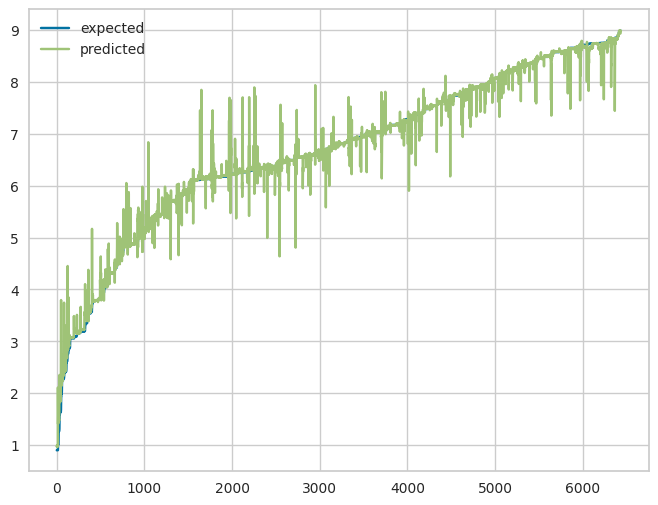

In [154]:
y_test_list = y_test.values

print(f'RMSE : {np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))}')
print(f'MAE :  {mean_absolute_error(y_true=y_test, y_pred=y_pred)}')

df = pd.DataFrame({'pred' : y_pred.flatten(), 'y' : y_test_list.flatten()})
df = df.sort_values('y')
plt.figure('figsize', (8,6))
plt.plot(df['y'].to_list(), label='expected')
plt.plot(df['pred'].to_list(), label='predicted')

plt.legend()

# _Final Predictions_

### _Import Data_

In [82]:
test = pd.read_csv('test_final.csv')
train = pd.read_csv('train_final.csv')

### _Scaling the Data_

In [83]:
train['days'] = QScaler.fit_transform(np.array(train['days'].values).reshape(-1,1))
test['days'] = QScaler.transform(np.array(test['days'].values).reshape(-1,1))

train['effectivity'] = QScaler.fit_transform(np.array(train['effectivity'].values).reshape(-1,1))
test['effectivity'] = QScaler.transform(np.array(test['effectivity'].values).reshape(-1,1))


train['number_of_times_prescribed'] = QScaler.fit_transform(np.array(train['number_of_times_prescribed'].values).reshape(-1,1))
test['number_of_times_prescribed'] = QScaler.transform(np.array(test['number_of_times_prescribed'].values).reshape(-1,1))

train['effectiveness_rating'] = QScaler.fit_transform(np.array(train['effectiveness_rating'].values).reshape(-1,1))
test['effectiveness_rating'] = QScaler.transform(np.array(test['effectiveness_rating'].values).reshape(-1,1))

### _Splitting Training data and Target_

In [100]:
train_final = train.drop(['patient_id', 'drug_approved_by_UIC', 'base_score', 'date'], axis=1)
target = train['base_score']

test_final = test.drop(['patient_id', 'drug_approved_by_UIC', 'base_score', 'date'], axis=1)

In [101]:
len(train_final.columns), len(test_final.columns)

(125, 125)

#### _Extracting Patient IDs_

In [112]:
ids = test['patient_id'].to_list()

### _Training Models_

In [102]:
models = {
    'CatBoost' : CatBoostRegressor(verbose=0, random_state=14),
    'Decision Tree' : DecisionTreeRegressor(random_state=14),
    'XGBoost' : XGBRegressor(random_state=14),
    'LightGBM' : LGBMRegressor(random_state=14),
    'Random Forest' : RandomForestRegressor(random_state=14)
}

for name, model in models.items():
    model.fit(train_final, target)
    print(name + " trained.")

CatBoost trained.
Decision Tree trained.
XGBoost trained.
LightGBM trained.
Random Forest trained.


# _Final Predictions_

In [103]:
final_predictions = (
    0.3 * (models['CatBoost'].predict(test_final)) +
    0.3 * (models['XGBoost'].predict(test_final)) +
    0.2 * (models['LightGBM'].predict(test_final)) +
    0.1 * (models['Random Forest'].predict(test_final)) +
    0.1 * (models['Decision Tree'].predict(test_final))
)

# _Submission_

In [124]:
Submission = pd.DataFrame(dict(zip(ids, final_predictions)), index=[0]).T.reset_index()
Submission.columns = ['patient_id', 'base_score']

In [128]:
Submission.to_csv('Submission.csv', index=False)